# Packages

In [1]:
from __future__ import print_function
import os
import time
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.misc
import imageio
#import cv2
from six.moves import urllib
import random
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from keras import backend as K
import torch
from tensorflow.keras.optimizers import Adam
#绘图显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  

由于tensorflow2.0版本不兼容很多函数，这里启用version1.0

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Other Functions

In [3]:
#定义预训练模型下载函数，将预训练模型从imagenet上下载到本地文件中
def Pre_Model_Download(download_link, file_name, expected_bytes):
    if os.path.exists(file_name):
        print("模型已经下载，模型就绪")
        return
    print("正在下载预训练的神经网络")
    #将URL表示的网络对象复制到本地文件，返回值为一个元组（filename，header）
    file_name, _ = urllib.request.urlretrieve(download_link, file_name)  #参数指定下载url以及保存到本地的路径
    #函数的返回是一个os.stat_result对象，用于给出一个文件或文件描述符（file descriptor）的各种状态信息
    file_stat = os.stat(file_name)
    if file_stat.st_size == expected_bytes:
        print('成功下载预训练的神经网络模型', file_name)
    else:
        raise Exception('文件：' + file_name +' 可能被占用，可以到网站上进行下载')

In [4]:
#定义初始化图片函数，主要用于将输入的图片修改为同样大小，神经网络可以接受的大小
def Resize_Image(img_path, height, width, save=True):
    image = Image.open(img_path)     #打开一个图片
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS)  #返回一个指定大小的裁剪过的图像，过滤器为ANTIALIAS
    if save:
        image_dirs = img_path.split('/')
        image_dirs[-1] = 'resized_' + image_dirs[-1]
        out_path = '/'.join(image_dirs)
        if not os.path.exists(out_path):
            image.save(out_path)
    image = np.asarray(image, np.float32)
    return np.expand_dims(image, 0)

In [5]:
#定义生成白噪声图片函数：未经学习的图像为白噪声形式，在神经网络不断训练后成为风格和内容图像合成的图像
def Noise_Image(content_image, height, width, noise_ratio=0.6):   #初始化白噪声比率为0.6
    #从一个均匀分布[-20,20)中随机采样，size为输入的图片，返回的形式与输入一致
    noise_image = np.random.uniform(-20, 20, (1, height, width, 3)).astype(np.float32) 
    return noise_image * noise_ratio + content_image * (1 - noise_ratio)

In [6]:
#定义图片保存函数，用于保存最终的输出结果
def Save_Image(path, image):
    image = image[0] 
    #利用np.clip截取数组中小于0或者大于255的部分，并使得被截取部分等于固定值。
    image = np.clip(image, 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [7]:
#创建文件夹
def make_dir(path):
    try:
        os.mkdir(path)
    except OSError:
        pass

## Image Processing：

In [8]:
#定义绘制内容图像、风格图像以及合成图像的函数，这里用于对比展示
def plot_images(content_image, style_image, mixed_image):
    #创建子图
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    #调整垂直间隔
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    #使用插值法平滑像素
    smooth = True
    
    #定义插值类型
    if smooth:
#        interpolation = 'sinc'
        interpolation = 'bilinear'    #图像处理改进：对于图片的插值类型进行了改变，sinc函数内插变为双线性插值
    else:
        interpolation = 'nearest'

    # 绘制内容图像；像素值被标准化至[0,1]中
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation = interpolation)
    ax.set_xlabel("内容图像")

    # 绘制合成图像
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("合成图像")

    # 绘制风格图像
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("风格图像")

    #从图像中去掉刻度
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [9]:
#定义图像加载函数
def load_image(filename, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # 计算合适的缩放因子以确保最大的图像高度和宽度，两者保证一个比例
        factor = max_size / np.max(image.size)
    
        # 缩放图像的长和宽
        size = np.array(image.size) * factor

        # 在缩放后，size变为浮点类型，而PIL要求输入为整数，这里进行数字类型转换
        size = size.astype(int)

        #重新改变图像的大小
        image = image.resize(size, Image.LANCZOS)

    # 转为numpy浮点类型矩阵
    return np.float32(image)

In [10]:
#定义权重函数，用于配制内容图像与风格图像融入到合成图像的比例
def Set_Weights(trained_layers, layer_idx, expected_layer_name):
    """ 返回已经训练的权重和偏置"""
    W = trained_layers[0][layer_idx][0][0][2][0][0]
    b = trained_layers[0][layer_idx][0][0][2][0][1]
    layer_name = trained_layers[0][layer_idx][0][0][0][0]
    
    assert layer_name == expected_layer_name
    
    b = b.reshape(b.size)
        
    return W, b

## Add new activation function into layers：

In [11]:
#设置卷积层搭建函数
#设置的参数分别为训练过的层，预训练的层，层索引，层名称，图像高度，图像宽度，组别（内容/风格），填充设为same表示输入和输出图像的大小相同
def Conv2d(trained_layers, prev_layer, layer_idx, layer_name, s_h, s_w, group, padding='SAME'):

    with tf.compat.v1.variable_scope(layer_name) as scope:
        w, b = Set_Weights(trained_layers, layer_idx, layer_name)  #对训练的层进行权重配置
        w = tf.constant(w, name='weights')  #创建常量权重
        b = tf.constant(b, name='bias')     #创建常量偏置
        
        convolve = lambda inputs, weigths: tf.nn.conv2d(inputs, weigths, [1, s_h, s_w, 1], padding=padding)
    
        if group==1:
            conv2d = convolve(prev_layer, w)
        else:
            # 将输入、权重和卷积层分开
            input_groups = tf.split(prev_layer, group, 3)
            kernel_groups = tf.split(w, group, 3)
            output_groups = [tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
                             for i, k in zip(input_groups, kernel_groups)]
            conv2d = tf.concat(output_groups, 3)
            
        conv_lin = tf.reshape(tf.nn.bias_add(conv2d, b), [-1] + conv2d.get_shape().as_list()[1:], name='lin')
#         conv_relu = tf.nn.relu(conv_lin, name='relu')  通常情况下，习惯使用ReLU函数
        conv_elu = tf.nn.elu(conv_lin, name='elu')   #创新点一：使用elu函数减小偏置带来的影响

        return conv_elu

### ELU activation function：

Input: [-5.         -4.28571429 -3.57142857 -2.85714286 -2.14285714 -1.42857143
 -0.71428571  0.          0.71428571  1.42857143  2.14285714  2.85714286
  3.57142857  4.28571429  5.        ]
Output: [-0.99326205 -0.98623621 -0.97188434 -0.94256738 -0.88268083 -0.76034896
 -0.51045834  0.          0.71428571  1.42857143  2.14285714  2.85714286
  3.57142857  4.28571429  5.        ]


2022-05-12 20:48:14.640148: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


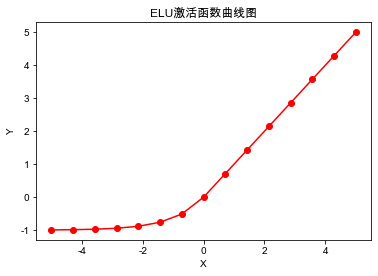

In [12]:
a = np.linspace(-5, 5, 15) 
  
b = tf.nn.elu(a, name ='elu') 
  
with tf.Session() as sess:
    print('Input:', a) 
    print('Output:', sess.run(b)) 
    plt.plot(a, sess.run(b), color = 'red', marker = "o")  
    plt.title("ELU激活函数曲线图")  
    plt.xlabel("X")  
    plt.ylabel("Y")  
  
    plt.show()

In [13]:
# 定义池化层函数
# 使用最大池化层效果最佳，取feature maps中最重要的特征
def MaxPool(prev_layer, layer_name):
    return tf.nn.max_pool(prev_layer, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID', name=layer_name)

def AvgPool(prev_layer, layer_name):
    return tf.nn.avg_pool(prev_layer, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID', name=layer_name)

In [14]:
#定义学习率函数
def Learning_rate(prev_layer, layer_name):  
    #使用了LRN局部响应归一化
    return tf.nn.local_response_normalization(prev_layer, depth_radius=2, alpha=2e-05, beta=0.75,bias=1.0,name=layer_name)

In [15]:
#加载文件中下载的预训练的网络
def load_net_from_file(path, input_image):

    net = scipy.io.loadmat(path)
    trained_layers = net['layers']
   
    graph = {} 
    graph['conv1']  = Conv2d(trained_layers , input_image, 0, 'conv1', s_h=4, s_w=4, group=1)
    graph['norm1']  = Learning_rate(graph['conv1'], 'norm1')
    graph['pool1']  = MaxPool(graph['norm1'], 'pool1')
    
    graph['conv2']  = Conv2d(trained_layers, graph['pool1'], 4, 'conv2', s_h=1, s_w=1, group=2)
    graph['norm2']  = Learning_rate(graph['conv2'], 'norm2')
    graph['pool2']  = MaxPool(graph['norm2'], 'pool2')
    
    graph['conv3']  = Conv2d(trained_layers, graph['pool2'], 8, 'conv3', s_h=1, s_w=1, group=1)
    graph['conv4']  = Conv2d(trained_layers, graph['conv3'], 10, 'conv4', s_h=1, s_w=1, group=2)
    graph['conv5']  = Conv2d(trained_layers, graph['conv4'], 12, 'conv5', s_h=1, s_w=1, group=2)    
    
    return graph

In [16]:
#用于计算内容图像与合成图像之间的特征损失
def Content_Loss(p, f):
    return tf.reduce_sum((f - p) ** 2) / (4.0 * p.size)

### Fix Gram matrix by adding shifted value for eliminating too many zero terms in Gram matrix to lower sparsity：

In [17]:
#定义Gram矩阵，用于计算风格特征损失
def Gram_Matrix(F, N, M):

    F = tf.reshape(F, (M, N))  #输入的F为tensor形式
    return tf.matmul(tf.transpose(F - 1), F - 1)   #这里使用matmul专门用于tensor的点乘
    #根据论文中所述：s = -1为最佳shifted value

In [18]:
#计算某一网络层的风格损失，a为真实图像的特征代表，g为生成图像的特征代表
def Single_Style_Loss(a, g):

    N = a.shape[3] # 过滤器个数
    M = a.shape[1] * a.shape[2] # feature map中高和宽之积
    A = Gram_Matrix(a, N, M)
    G = Gram_Matrix(g, N, M)
    
    return tf.reduce_sum((G - A) ** 2 / ((2 * N * M) ** 2))

In [19]:
#定义总的风格损失函数
def Style_Loss(A, model):
    
    n_layers = len(STYLE_LAYERS)
    E = [Single_Style_Loss(A[i], model[STYLE_LAYERS[i]]) for i in range(n_layers)]
    
    return sum([W[i] * E[i] for i in range(n_layers)])

In [20]:
#计算总损失（内容损失 + 风格损失）
def Total_Loss(model, input_image, content_image, style_image):
    with tf.compat.v1.variable_scope('loss') as scope:
        with tf.compat.v1.Session() as sess:
            sess.run(input_image.assign(content_image)) # 指定内容图像至输入变量
            p = sess.run(model[CONTENT_LAYER])
        content_loss = Content_Loss(p, model[CONTENT_LAYER])

        with tf.compat.v1.Session() as sess:
            sess.run(input_image.assign(style_image))
            A = sess.run([model[layer_name] for layer_name in STYLE_LAYERS])                              
        style_loss = Style_Loss(A, model)

        total_loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
       
    return content_loss, style_loss, total_loss

In [21]:
# 对模型配置进行整体概览
def Summary(model):
    
    with tf.name_scope('summaries'):
        tf.summary.scalar('content loss', model['content_loss'])
        tf.summary.scalar('style loss', model['style_loss'])
        tf.summary.scalar('total loss', model['total_loss'])
        tf.summary.histogram('histogram content loss', model['content_loss'])
        tf.summary.histogram('histogram style loss', model['style_loss'])
        tf.summary.histogram('histogram total loss', model['total_loss'])
        return tf.compat.v1.summary.merge_all()

# Parameters setting

In [23]:
DOWNLOAD_LINK = 'http://www.vlfeat.org/matconvnet/models/imagenet-caffe-alex.mat'
File_MODEL_PATH = 'imagenet-caffe-alex.mat'
EXPECTED_BYTES = 228041398   

MODEL_NET_NAME = './Alexnet_Style_Transfer_results/alexnet'   #根路径
OUTPUT_PATH = MODEL_NET_NAME + '_outputs'            #合成图片输出路径
CHECKPOINT_PATH = MODEL_NET_NAME + '_checkpoints'    #训练节点输出路径
GRAPHS_PATH = MODEL_NET_NAME + '_graphs'            #网络输出路径

#定义读取内容图像和风格图像的路径

# mylist = os.listdir('./Test_dataset/')
# root_path = './Test_dataset/'

#random.seed(1)
#CONTENT_IMAGE_PATH = root_path + random.choice(mylist) 
CONTENT_IMAGE_PATH = './Test_dataset_stylesplit/style1/000000001730.jpg'


STYLE_IMAGE_PATH = './Alexnet_Style_Transfer_results/style_input/Van_Gogh_starry_sky.jpg'


img_original = Image.open(CONTENT_IMAGE_PATH)  #读取内容图像表示的二维矩阵

IMAGE_HEIGHT = img_original.height  #将生成图像的长和宽与原内容图像保持一致
IMAGE_WIDTH = img_original.width

CONTENT_WEIGHT = 0.01   #内容图像权重
STYLE_WEIGHT = 1       #风格图像权重

NOISE_RATIO = 0.6     #白噪声与原内容图像混合的比例

ITERS = 200           #迭代次数
LR = 2.0              #固定学习率


# 指定用于风格特征的网络层
STYLE_LAYERS = ['conv1', 'conv3', 'conv4', 'conv5']
#越深的层数指定更大的权重
W = [0.1, 0.2, 0.3, 0.4] 

# 指定用于内容特征的网络层
CONTENT_LAYER = 'conv2'

#这里的数组是RGB通道固定数值
MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

FileNotFoundError: [Errno 2] No such file or directory: './Test_dataset_stylesplit/style1/000000001730.jpg'

# Training

In [122]:
#定义模型训练函数，输入参数为模型，生成图片以及初始化图片
def train(model, generated_image, initial_image):
    """ 模型训练 """
    skip_step = 1   #设置skip的目的是不需要展示所有的训练步骤，去间隔值进行展示
    with tf.compat.v1.Session() as sess:
        
        saver = tf.compat.v1.train.Saver()  #用于保存、恢复变量或模型
        sess.run(tf.compat.v1.global_variables_initializer())  #在含有tf.Variable的环境下，进行初始化全局变量
        writer = tf.compat.v1.summary.FileWriter(GRAPHS_PATH, sess.graph) #读取图片
        
        sess.run(generated_image.assign(initial_image))    #首先对生成图像分配初始化白噪声图像
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(CHECKPOINT_PATH))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        initial_step = model['global_step'].eval()  #用于计算返回numpy结果
        
        start_time = time.time()   #设计一个训练模型的时间返回器
        for index in range(initial_step, ITERS):
            if index >= 5 and index < 20:
                skip_step = 10
            elif index >= 20:
                skip_step = 20
            
            sess.run(model['optimizer'])
            if (index + 1) % skip_step == 0:   #展示训练过程中的图片以及损失
                gen_image, total_loss, summary = sess.run([generated_image, model['total_loss'], model['summary_op']])
                gen_image = gen_image + MEAN_PIXELS
                writer.add_summary(summary, global_step=index)
                print('第 {} 步\n  总和为: {:5.1f}'.format(index + 1, np.sum(gen_image)))
                print('总损失为: {:5.1f}'.format(total_loss))
                print('本次训练所用时长: {}'.format(time.time() - start_time))
                start_time = time.time()

                filename = OUTPUT_PATH + '/%d.png' % (index)   #保存生成的合成图像
                
                Save_Image(filename, gen_image)
                
                #加载图像并合并以更好地展示对比
                c_image = load_image(CONTENT_IMAGE_PATH,max_size=IMAGE_HEIGHT)
                s_image = load_image(STYLE_IMAGE_PATH,max_size=IMAGE_HEIGHT)
                g_image = load_image(filename,max_size=IMAGE_HEIGHT)
                plot_images(content_image=c_image,style_image=s_image,mixed_image=g_image)
                
                if (index + 1) % 20 == 0:
                    saver.save(sess, CHECKPOINT_PATH + '/style_transfer', index)

In [123]:
def main():
    with tf.compat.v1.variable_scope('input') as scope:
        # 使用variable而不是placeholder，让生成图像结合内容图像和风格图像
        input_image = tf.Variable(np.zeros([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3]), dtype=tf.float32)
        # 加载预训练模型
        Pre_Model_Download(DOWNLOAD_LINK, File_MODEL_PATH, EXPECTED_BYTES)
        
    make_dir(CHECKPOINT_PATH)
    make_dir(OUTPUT_PATH)
    
    model = load_net_from_file(File_MODEL_PATH, input_image)
    model['global_step'] = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

    #重新调整内容图像以及风格图像的大小
    content_image = Resize_Image(CONTENT_IMAGE_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
    content_image = content_image - MEAN_PIXELS
    
  
    style_image = Resize_Image(STYLE_IMAGE_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
    style_image = style_image - MEAN_PIXELS

    #计算三个损失
    model['content_loss'], model['style_loss'], model['total_loss'] = Total_Loss(model, input_image, content_image, style_image)
    
    #迭代优化，选择Adam优化器线性优化
    model['optimizer'] = tf.compat.v1.train.AdamOptimizer(LR).minimize(model['total_loss'], global_step=model['global_step'])
    
    model['summary_op'] = Summary(model)

    initial_image = Noise_Image(content_image, IMAGE_HEIGHT, IMAGE_WIDTH, NOISE_RATIO)
    
    train(model, input_image, initial_image)

In [124]:
start_time = time.time()

main()
    
end_time = time.time()
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))

print("模型训练总时长为: %s" % elapsed_time)

模型已经下载，模型就绪


TypeError: elu() got an unexpected keyword argument 'alpha'